In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

C:\Users\lg\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [43]:
data = pd.read_csv("realdata.csv")

In [44]:
data

,Unnamed: 0,발화문,감정
0,0,"어, 청소 니가 대신 해 줘!",0
1,1,둘 다 청소 하기 싫어. 귀찮아.,0
2,2,둘 다 하기 싫어서 화내.,1
3,3,그럼 방세는 어떡해.,2
4,4,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,2
...,...,...,...
42018,42018,나 엘리베이터에 갇혔어.,2
42019,42019,하지만 기분이 나쁜 걸 어떡해?,2
42020,42020,자취방 엘리베이턴데 정전인가봐.,2
42021,42021,나 드디어 프로젝트 끝났어!,2


In [49]:
train_data = data[:38000]

In [50]:
test_data = data[38001:]

In [48]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [52]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
X_train = []
for sentence in train_data['발화문']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['발화문']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [53]:
from keras.preprocessing.text import Tokenizer
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

문장의 최대 길이 :  44
문장의 평균 길이 :  9.73663157894737


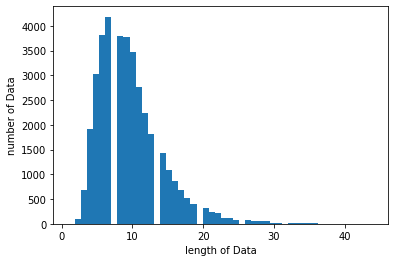

In [55]:
print("문장의 최대 길이 : ", max(len(l) for l in X_train))
print("문장의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [58]:
y_train = np.array(pd.get_dummies(train_data['감정'],drop_first=True))

In [59]:
y_test = np.array(pd.get_dummies(test_data['감정'],drop_first=True))

In [65]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
max_len = 40 # 전체 데이터의 길이를 40로 맞춘다

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [64]:
X_test

array([[  0,   0,   0, ...,  91,  53,  12],
       [  0,   0,   0, ...,  19, 935,   1],
       [  0,   0,   0, ...,   1,  91,  12],
       ...,
       [  0,   0,   0, ..., 685,  19,   1],
       [  0,   0,   0, ..., 183, 158,  11],
       [  0,   0,   0, ...,  77,  57,   1]])

In [67]:
y_test

array([[False, False, False, False, False, False],
       [False, False, False, False, False,  True],
       [False, False, False, False, False, False],
       ...,
       [False,  True, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False]])

In [68]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

Epoch 1/10
3420/3420 [==============================] - 79s 23ms/step - loss: 1.1896 - accuracy: 0.4888 - val_loss: 0.8200 - val_accuracy: 0.2263
Epoch 2/10
3420/3420 [==============================] - 104s 30ms/step - loss: 1.0197 - accuracy: 0.5713 - val_loss: 0.7713 - val_accuracy: 0.3608
Epoch 3/10
3420/3420 [==============================] - 104s 31ms/step - loss: 0.9555 - accuracy: 0.5815 - val_loss: 0.7517 - val_accuracy: 0.2845
Epoch 4/10
3420/3420 [==============================] - 103s 30ms/step - loss: 0.9391 - accuracy: 0.5809 - val_loss: 0.7445 - val_accuracy: 0.2805
Epoch 5/10
3420/3420 [==============================] - 104s 30ms/step - loss: 0.9461 - accuracy: 0.5792 - val_loss: 0.7407 - val_accuracy: 0.2347
Epoch 6/10
3420/3420 [==============================] - 104s 30ms/step - loss: 0.9563 - accuracy: 0.5770 - val_loss: 0.7948 - val_accuracy: 0.2197
Epoch 7/10
3420/3420 [==============================] - 103s 30ms/step - loss: 0.9628 - accuracy: 0.5751 - val_loss: 0.

In [69]:
model.evaluate(X_test, y_test)

126/126 [==============================] - 1s 6ms/step - loss: 0.8222 - accuracy: 0.2670


[0.8221970796585083, 0.26703134179115295]

In [70]:
predict = model.predict(X_test)

126/126 [==============================] - 1s 6ms/step


In [71]:
import numpy as np
predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)


In [74]:
for i in range(30):
    print("발화문 : ", test_data['발화문'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])

발화문 :  그건 어떻게 알았어? /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  그러게. 저거 뉴스에서 보면 재밌겠다. /	 원래 라벨 :  5 /	예측한 라벨 :  1
발화문 :  음. 기분이 너무 별로야. 어떻게 하지? /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  응. 니가 더 기분 나쁘고. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  그럼 또라이한테 욕 박지 뭐하냐. /	 원래 라벨 :  2 /	예측한 라벨 :  0
발화문 :  전화해서 환불 받으면 되려나? /	 원래 라벨 :  3 /	예측한 라벨 :  1
발화문 :  많이 무기력해. /	 원래 라벨 :  1 /	예측한 라벨 :  1
발화문 :  응. 정말 뿌듯하더라. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  나 엘리베이터에 갇혔어. /	 원래 라벨 :  4 /	예측한 라벨 :  0
발화문 :  궁금한 거 없었는데. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  너는 말귀를 참 못알아먹는구나. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  어. 지금 바로 해보려고. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  내려간 다음에 회복이 되지 않아. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  나 축하해줘. 기분 좋은 일이 있어. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  나 오늘 짭새가 몰려있길래 구경갔다왔어. /	 원래 라벨 :  1 /	예측한 라벨 :  1
발화문 :  빠르게 치워보도록 할게. 고마워. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  좋은 생각인 것 같아. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  잘 모르겠는데 안에서 뭔가 썩은 것 같아. /	 원래 라벨 :  0 /	예측한 라벨 :  1
발화문 :  쓰레기통에서 존나 역겨운 냄새가 나고있어. /	 원래 라벨 :  0 /	예측한 라벨 :  0
발화

In [80]:
pd.DataFrame(predict_labels)[0].unique()

array([1, 0, 5], dtype=int64)